In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


In [2]:
import os, pickle

base_dir = "variables_all_mouse/day_outputs"
day_outputs = {}

for fname in os.listdir(base_dir):
    if not fname.endswith("_day_outputs.pkl"):
        continue

    mouse = fname.split("_")[0]               
    path  = os.path.join(base_dir, fname)
    with open(path, "rb") as f:
        mouse_data = pickle.load(f)        
    day_outputs[mouse] = mouse_data

print("Loaded day_outputs for mice:", list(day_outputs.keys()))

raw = day_outputs  

day_outputs_flat = {}
for outer_key, nested in raw.items():
    if isinstance(nested, dict) and len(nested)==1:
        real_mouse = next(iter(nested))       
        day_outputs_flat[real_mouse] = nested[real_mouse]
    else:
        day_outputs_flat[outer_key] = nested

day_outputs = day_outputs_flat

print("Now day_outputs keys:", list(day_outputs.keys()))



Loaded day_outputs for mice: ['M9', 'M8', 'M11', 'M23', 'M28']
Now day_outputs keys: ['NN9', 'NN8', 'NN11', 'NN23', 'NN28']


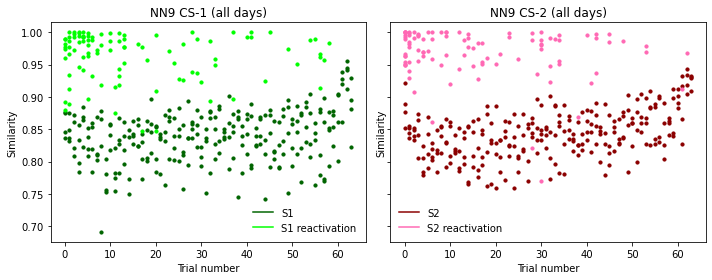

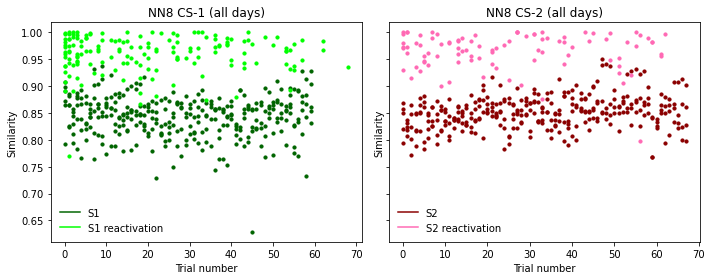

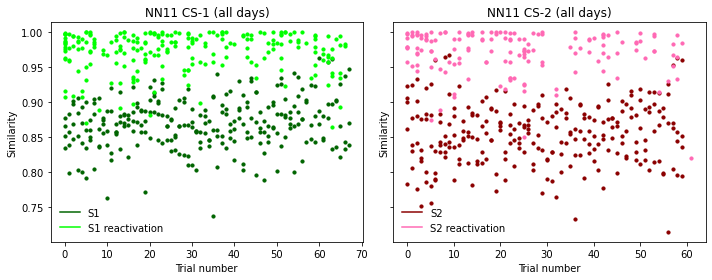

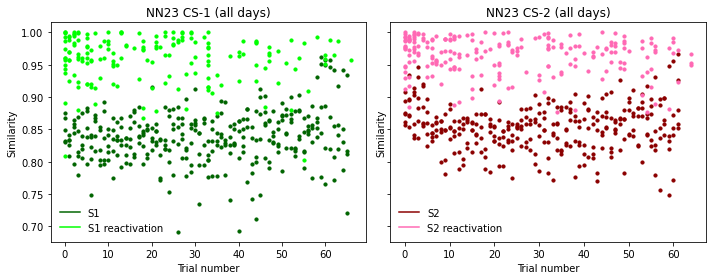

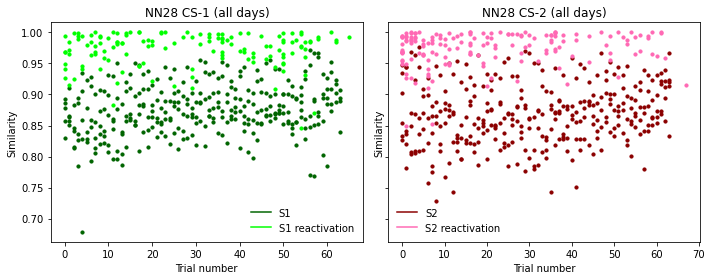

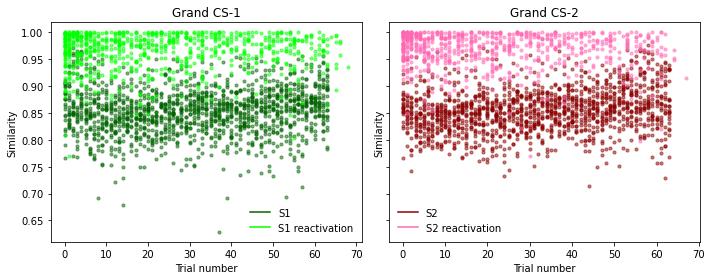

(103,)
(99,)
(160,)
(95,)
(228,)
(153,)
(175,)
(217,)
(144,)
(168,)


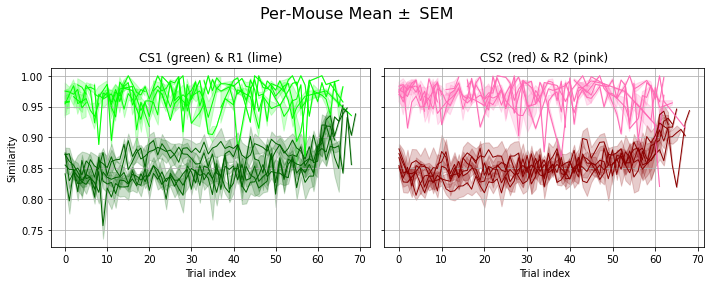

In [47]:
def plot_panel(ax, sim_cs, sim_r, trials_r, colors, labels, alpha, cs_x=None, reac_x=None):
    """
    If cs_x is given, use it for the CS scatter; otherwise default to range(len(sim_cs)).
    If reac_x is given, use it for the R scatter; otherwise use trials_r.
    """
    x_cs = cs_x if cs_x is not None else np.arange(len(sim_cs))
    x_r  = reac_x if reac_x is not None else trials_r

    ax.scatter(x_cs, sim_cs,   color=colors[0], s=10, alpha=alpha)
    ax.scatter(x_r,  sim_r,    color=colors[1], s=10, alpha=alpha)
    ax.set_xlabel('Trial number')
    ax.set_ylabel(labels[2])
    ax.legend(handles=[
        mlines.Line2D([], [], color=colors[0], label=labels[0]),
        mlines.Line2D([], [], color=colors[1], label=labels[1])
    ], frameon=False)
    return ax


def plot_mouse_summary(mouse, day_dict):
    # gather flat lists
    all_cs1, all_r1, all_t1 = [], [], []
    all_cs2, all_r2, all_t2 = [], [], []
    for out in day_dict.values():
        all_cs1.extend(out['sim_cs_1'])
        all_r1.extend(out['sim_r_1'])
        all_t1.extend(out['trial_r_1'])
        all_cs2.extend(out['sim_cs_2'])
        all_r2.extend(out['sim_r_2'])
        all_t2.extend(out['trial_r_2'])

    # figure out the original CS‐trial length
    first_out = next(iter(day_dict.values()))
    n_cs1 = len(first_out['sim_cs_1'])
    n_cs2 = len(first_out['sim_cs_2'])
    # tile 0..n_cs−1 across the concatenated list
    cs1_x = np.arange(len(all_cs1)) % n_cs1
    cs2_x = np.arange(len(all_cs2)) % n_cs2

    fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
    plot_panel(axes[0],
               sim_cs=all_cs1, sim_r=all_r1, trials_r=all_t1,
               colors=('darkgreen','lime'),
               labels=('S1','S1 reactivation','Similarity'),
               alpha=1,
               cs_x=cs1_x)

    axes[0].set_title(f"{mouse} CS-1 (all days)")
    plot_panel(axes[1],
               sim_cs=all_cs2, sim_r=all_r2, trials_r=all_t2,
               colors=('darkred','hotpink'),
               labels=('S2','S2 reactivation','Similarity'),
               alpha=1,
               cs_x=cs2_x)

    axes[1].set_title(f"{mouse} CS-2 (all days)")
    plt.tight_layout()
    plt.show()


def plot_grand_summary(day_outputs):
    all_cs1, all_r1, all_t1 = [], [], []
    all_cs2, all_r2, all_t2 = [], [], []
    for day_dict in day_outputs.values():
        for out in day_dict.values():
            all_cs1.extend(out['sim_cs_1'])
            all_r1.extend(out['sim_r_1'])
            all_t1.extend(out['trial_r_1'])
            all_cs2.extend(out['sim_cs_2'])
            all_r2.extend(out['sim_r_2'])
            all_t2.extend(out['trial_r_2'])

    any_out = next(iter(next(iter(day_outputs.values())).values()))
    n_cs1 = len(any_out['sim_cs_1'])
    n_cs2 = len(any_out['sim_cs_2'])
    cs1_x = np.arange(len(all_cs1)) % n_cs1
    cs2_x = np.arange(len(all_cs2)) % n_cs2

    trials1 = np.arange(n_cs1)
    mean_cs1 = [np.mean([v for v,x in zip(all_cs1, cs1_x) if x==t]) for t in trials1]
    trialsr1 = sorted(set(all_t1))
    mean_r1 = [np.mean([v for v,x in zip(all_r1, all_t1) if x==t]) for t in trialsr1]

    trials2 = np.arange(n_cs2)
    mean_cs2 = [np.mean([v for v,x in zip(all_cs2, cs2_x) if x==t]) for t in trials2]
    trialsr2 = sorted(set(all_t2))
    mean_r2 = [np.mean([v for v,x in zip(all_r2, all_t2) if x==t]) for t in trialsr2]

    fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
    plot_panel(axes[0],
               sim_cs=all_cs1, sim_r=all_r1, trials_r=all_t1,
               colors=('darkgreen','lime'),
               labels=('S1','S1 reactivation','Similarity'),
               alpha = 0.5,
               cs_x=cs1_x)
    axes[0].set_title("Grand CS-1")
    plot_panel(axes[1],
               sim_cs=all_cs2, sim_r=all_r2, trials_r=all_t2,
               colors=('darkred','hotpink'),
               labels=('S2','S2 reactivation','Similarity'),
               alpha = 0.5,
               cs_x=cs2_x)
    axes[1].set_title("Grand CS-2")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
    fig.suptitle("Per‐Mouse Mean ±  SEM", fontsize=16)

    for mouse, days in day_outputs.items():
        cs1_lens = [len(out['sim_cs_1']) for out in days.values()]
        cs2_lens = [len(out['sim_cs_2']) for out in days.values()]
        max_cs1 = max(cs1_lens)
        max_cs2 = max(cs2_lens)

        cs1_mat = []
        for out in days.values():
            arr = out['sim_cs_1']
            if len(arr) < max_cs1:
                pad = np.full(max_cs1 - len(arr), np.nan)
                arr = np.concatenate([arr, pad])
            cs1_mat.append(arr)
        cs1_mat = np.vstack(cs1_mat)  # now safe

        # same for CS2
        cs2_mat = []
        for out in days.values():
            arr = out['sim_cs_2']
            if len(arr) < max_cs2:
                pad = np.full(max_cs2 - len(arr), np.nan)
                arr = np.concatenate([arr, pad])
            cs2_mat.append(arr)
        cs2_mat = np.vstack(cs2_mat)

        mean_cs1 = np.nanmean(cs1_mat, axis=0)
        std_cs1  = np.nanstd( cs1_mat, axis=0)
        mean_cs2 = np.nanmean(cs2_mat, axis=0)
        std_cs2  = np.nanstd( cs2_mat, axis=0)
        n_sessions = cs1_mat.shape[0]
        sem_cs1 = std_cs1 / np.sqrt(n_sessions)
        sem_cs2 = std_cs2 / np.sqrt(n_sessions)

        t_cs1 = np.arange(max_cs1)
        t_cs2 = np.arange(max_cs2)

        all_r1    = np.concatenate([out['sim_r_1']   for out in days.values()])
        print(all_r1.shape)
        all_tr1   = np.concatenate([out['trial_r_1'] for out in days.values()])
        trial_idx1 = np.unique(all_tr1)
        mean_r1 = np.array([ all_r1[all_tr1==t].mean() for t in trial_idx1 ])
        std_r1  = np.array([ all_r1[all_tr1==t].std()  for t in trial_idx1 ])
        sem_r1 = std_r1 / np.sqrt(n_sessions)

        all_r2    = np.concatenate([out['sim_r_2']   for out in days.values()])
        print(all_r2.shape)

        all_tr2   = np.concatenate([out['trial_r_2'] for out in days.values()])
        trial_idx2 = np.unique(all_tr2)
        mean_r2 = np.array([ all_r2[all_tr2==t].mean() for t in trial_idx2 ])
        std_r2  = np.array([ all_r2[all_tr2==t].std()  for t in trial_idx2 ])
        sem_r2 = std_r2 / np.sqrt(n_sessions)

        ax = axes[0]
        ax.plot(t_cs1, mean_cs1, color='darkgreen', linewidth=1)
        ax.fill_between(t_cs1, mean_cs1-sem_cs1, mean_cs1+sem_cs1,
                        color='darkgreen', alpha=0.2)
        ax.plot(trial_idx1, mean_r1, color='lime', linewidth=1)
        ax.fill_between(trial_idx1, mean_r1-sem_r1, mean_r1+sem_r1,
                        color='lime', alpha=0.2)

        # CS2 & R2 on axes[1]
        ax = axes[1]
        ax.plot(t_cs2, mean_cs2, color='darkred', linewidth=1)
        ax.fill_between(t_cs2, mean_cs2-sem_cs2, mean_cs2+sem_cs2,
                        color='darkred', alpha=0.2)
        ax.plot(trial_idx2, mean_r2, color='hotpink', linewidth=1)
        ax.fill_between(trial_idx2, mean_r2-sem_r2, mean_r2+sem_r2,
                        color='hotpink', alpha=0.2)

    axes[0].set_title("CS1 (green) & R1 (lime)")
    axes[0].set_xlabel("Trial index")
    axes[0].set_ylabel("Similarity")
    axes[0].grid(True)

    axes[1].set_title("CS2 (red) & R2 (pink)")
    axes[1].set_xlabel("Trial index")
    axes[1].grid(True)

    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()



for mouse, days in day_outputs.items():
    plot_mouse_summary(mouse, days)

plot_grand_summary(day_outputs)


(322,) (318,)
(121,) (102,)


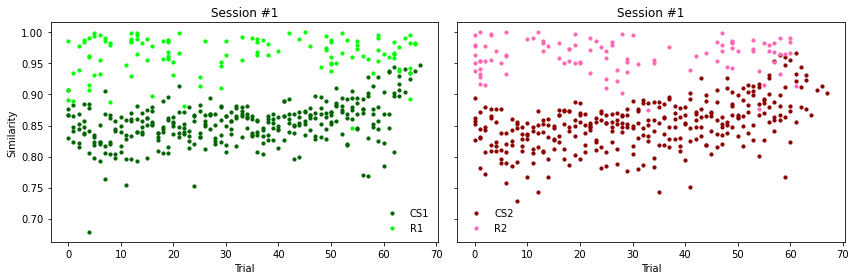

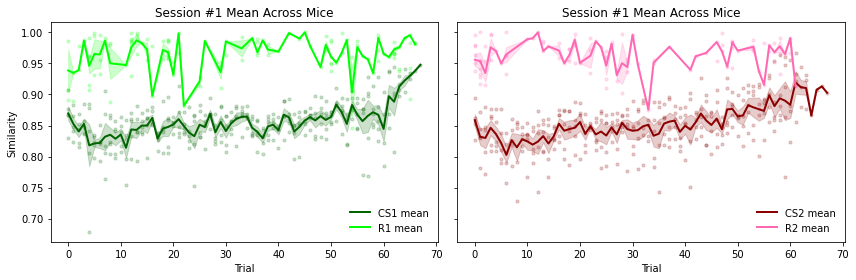

(325,) (315,)
(184,) (158,)


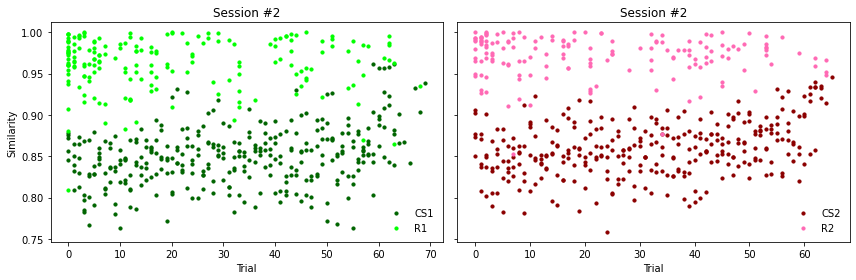

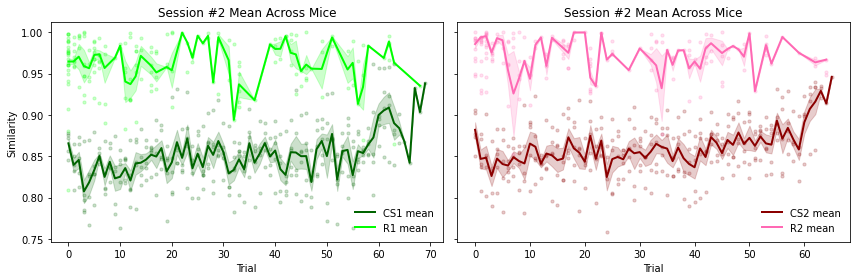

(313,) (327,)
(189,) (180,)


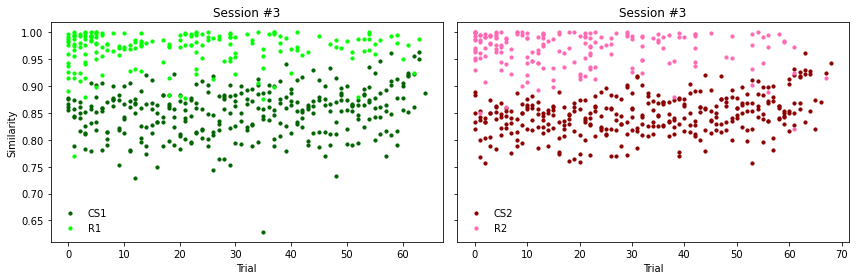

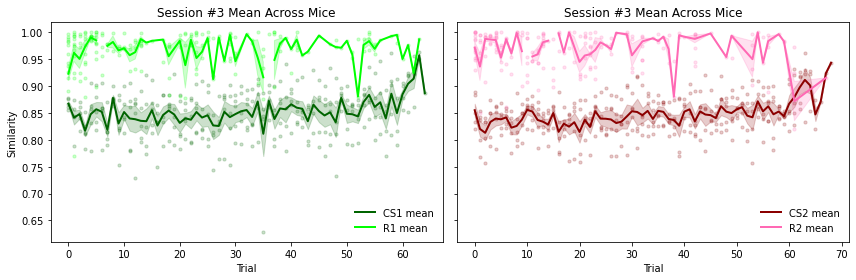

(328,) (312,)
(195,) (183,)


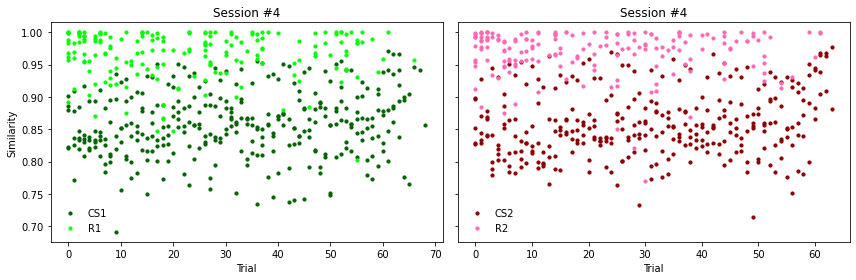

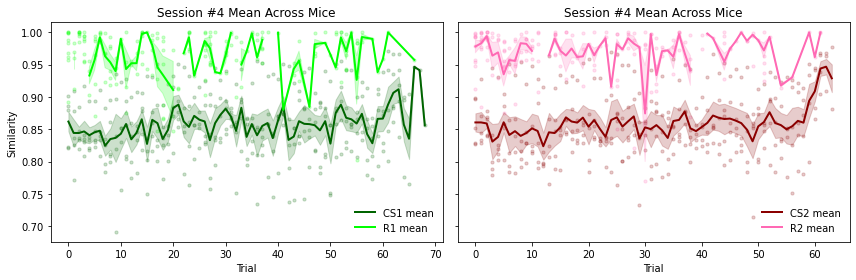

(192,) (192,)
(121,) (109,)


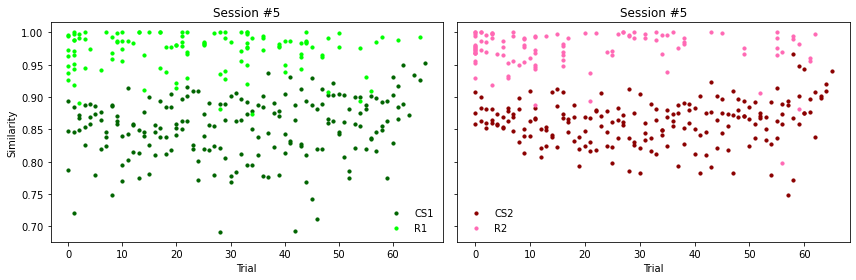

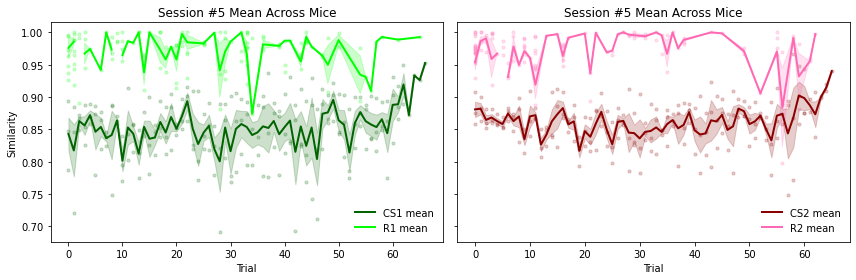

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def plot_by_session_index(day_outputs):
    """
    day_outputs: dict of mouse → dict of session_key → out_dict
       out_dict must have keys:
         'sim_cs_1','sim_r_1','trial_r_1',
         'sim_cs_2','sim_r_2','trial_r_2'
    This will produce one figure‐pair per session‐index (1st session across mice, 2nd session, etc).
    """
    max_sess = max(len(days) for days in day_outputs.values())
    
    for sess_idx in range(max_sess):
        cs1_list = []; r1_list = []; t1_list = []; r1a_list = []
        cs2_list = []; r2_list = []; t2_list = []; r2a_list = []
        
        for mouse, days in day_outputs.items():
            day_items = sorted(days.items(), key=lambda x: x[0])
            if sess_idx < len(day_items):
                _, out = day_items[sess_idx]
                cs1_list.append(np.asarray(out['sim_cs_1']))
                r1_list .append(np.asarray(out['sim_r_1']))
                t1_list .append(np.asarray(out['trial_r_1']))
                cs2_list.append(np.asarray(out['sim_cs_2']))
                r2_list .append(np.asarray(out['sim_r_2']))
                t2_list .append(np.asarray(out['trial_r_2']))
        
        if not cs1_list:
            continue
        
        all_cs1 = np.concatenate(cs1_list)
        all_r1  = np.concatenate(r1_list)
        all_t1  = np.concatenate(t1_list)
        all_cs2 = np.concatenate(cs2_list)
        all_r2  = np.concatenate(r2_list)
        all_t2  = np.concatenate(t2_list)

        print(all_cs1.shape, all_cs2.shape)


        cs1_x = np.concatenate([np.arange(len(a)) for a in cs1_list])
        cs2_x = np.concatenate([np.arange(len(a)) for a in cs2_list])
        print(all_r1.shape, all_r2.shape)
        
        # —— 1) RAW scatter —— 
        fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
        axes[0].scatter(cs1_x, all_cs1, color='darkgreen', s=10, alpha=1, label='CS1')
        axes[0].scatter(all_t1, all_r1, color='lime',     s=10, alpha=1, label='R1')
        axes[0].set_title(f"Session #{sess_idx+1}")
        axes[0].set_xlabel("Trial"); axes[0].set_ylabel("Similarity")
        axes[0].legend(frameon=False)

        axes[1].scatter(cs2_x, all_cs2, color='darkred',  s=10, alpha=1, label='CS2')
        axes[1].scatter(all_t2, all_r2, color='hotpink', s=10, alpha=1, label='R2')
        axes[1].set_title(f"Session #{sess_idx+1}")
        axes[1].set_xlabel("Trial")
        axes[1].legend(frameon=False)

        plt.tight_layout()
        plt.show()



        def pad_stack(arrs):
            target = max(len(a) for a in arrs)
            mats = []
            for a in arrs:
                if len(a) < target:
                    pad = np.full(target - len(a), np.nan)
                    a = np.concatenate([a, pad])
                mats.append(a)
            return np.vstack(mats)
        n_mice = len(cs1_list)
        cs1_mat = pad_stack(cs1_list)
        cs2_mat = pad_stack(cs2_list)
        mean_cs1 = np.nanmean(cs1_mat, axis=0)
        mean_cs2 = np.nanmean(cs2_mat, axis=0)
        sem_cs1 = np.nanstd(cs1_mat, axis= 0) / np.sqrt(n_mice)
        sem_cs2 = np.nanstd(cs2_mat, axis= 0) / np.sqrt(n_mice)

        def mean_by_trial(r_arrs, t_arrs):
            all_t = np.unique(np.concatenate(t_arrs))
            means, stds, counts = [], [], []
            for t in all_t:
                vals = [r[np.where(tt==t)[0][0]]
                        for r,tt in zip(r_arrs, t_arrs)
                        if np.any(tt==t)]
                if vals:
                    means.append(np.mean(vals))
                    stds .append(np.std(vals, ddof=0))  # population‐std
                    counts.append(len(vals))
                else:
                    means.append(np.nan)
                    stds .append(np.nan)
                    counts.append(0)
            return all_t, np.array(means), np.array(stds), np.array(counts)

        trial_idx1, mean_r1, std_r1, cnt_r1 = mean_by_trial(r1_list, t1_list)
        trial_idx2, mean_r2, std_r2, cnt_r2 = mean_by_trial(r2_list, t2_list)

        sem_r1 = std_r1 / np.sqrt(cnt_r1)
        sem_r2 = std_r2 / np.sqrt(cnt_r2)

        fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
        axes[0].scatter(cs1_x, all_cs1, color='darkgreen', s=10, alpha=0.2)
        axes[0].scatter(all_t1, all_r1, color='lime',     s=10, alpha=0.2)
        axes[0].plot(np.arange(mean_cs1.size), mean_cs1, color='darkgreen', linewidth=2)
        axes[0].fill_between(np.arange(mean_cs1.size), mean_cs1-sem_cs1, mean_cs1+sem_cs1, color= 'darkgreen', alpha=0.2)
        axes[0].plot(trial_idx1,             mean_r1,  color='lime',       linewidth=2)
        axes[0].fill_between(trial_idx1, mean_r1-sem_r1, mean_r1+sem_r1, color= 'lime', alpha=0.2)

        axes[0].set_title(f"Session #{sess_idx+1} Mean Across Mice")
        axes[0].set_xlabel("Trial"); axes[0].set_ylabel("Similarity")
        axes[0].legend(['CS1 mean','R1 mean'], loc='lower right', frameon=False)

        axes[1].scatter(cs2_x, all_cs2, color='darkred',  s=10, alpha=0.2)
        axes[1].scatter(all_t2, all_r2, color='hotpink', s=10, alpha=0.2)
        axes[1].plot(np.arange(mean_cs2.size), mean_cs2, color='darkred',   linewidth=2)
        axes[1].fill_between(np.arange(mean_cs2.size), mean_cs2-sem_cs2, mean_cs2+sem_cs2, color= 'darkred', alpha=0.2)
        axes[1].plot(trial_idx2,             mean_r2,  color='hotpink',   linewidth=2)
        axes[1].fill_between(trial_idx2, mean_r2-sem_r2, mean_r2+sem_r2, color= 'hotpink', alpha=0.2)

        axes[1].set_title(f"Session #{sess_idx+1} Mean Across Mice")
        axes[1].set_xlabel("Trial")
        axes[1].legend(['CS2 mean','R2 mean'], loc='lower right', frameon=False)

        plt.tight_layout()
        plt.show()

plot_by_session_index(day_outputs)

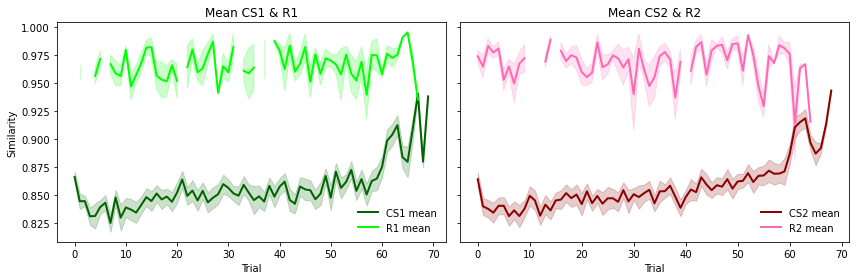

In [49]:

def plot_aggregate_first_four(day_outputs):
    """
    Pools the first 4 sessions of every mouse, then plots the grand mean ± SEM
    for CS1 vs R1 and CS2 vs R2 across *all* those sessions+ mice.
    """
    cs1_list, r1_list, t1_list = [], [], []
    cs2_list, r2_list, t2_list = [], [], []

    for mouse, days in day_outputs.items():
        first4 = sorted(days.items(), key=lambda x: x[0])[:4]
        for _, out in first4:
            cs1_list.append(np.asarray(out['sim_cs_1']))
            r1_list .append(np.asarray(out['sim_r_1']))
            t1_list .append(np.asarray(out['trial_r_1']))
            cs2_list.append(np.asarray(out['sim_cs_2']))
            r2_list .append(np.asarray(out['sim_r_2']))
            t2_list .append(np.asarray(out['trial_r_2']))

    def pad_stack(arrs):
        maxlen = max(len(a) for a in arrs)
        mats = []
        for a in arrs:
            if len(a) < maxlen:
                a = np.concatenate([a, np.full(maxlen-len(a), np.nan)])
            mats.append(a)
        return np.vstack(mats)

    cs1_mat = pad_stack(cs1_list)
    mean_cs1 = np.nanmean(cs1_mat, axis=0)
    sem_cs1  = np.nanstd( cs1_mat, axis=0) / np.sqrt(cs1_mat.shape[0])

    cs2_mat = pad_stack(cs2_list)
    mean_cs2 = np.nanmean(cs2_mat, axis=0)
    sem_cs2  = np.nanstd( cs2_mat, axis=0) / np.sqrt(cs2_mat.shape[0])

    r1_mat = pad_stack(r1_list)
    mean_r1 = np.nanmean(r1_mat, axis=0)
    sem_r1  = np.nanstd( r1_mat, axis=0) / np.sqrt(r1_mat.shape[0])

    r2_mat = pad_stack(r2_list)
    mean_r2 = np.nanmean(r2_mat, axis=0)
    sem_r2  = np.nanstd( r2_mat, axis=0) / np.sqrt(r2_mat.shape[0])

    def mean_sem_by_trial(r_arrs, t_arrs):
        trials = np.unique(np.concatenate(t_arrs))
        means, sems = [], []
        for t in trials:
            vals = [r[np.where(tt==t)[0][0]]
                    for r,tt in zip(r_arrs, t_arrs)
                    if np.any(tt==t)]
            m = np.mean(vals)
            s = np.std(vals, ddof=0)/np.sqrt(len(vals))
            means.append(m)
            sems.append(s)
        return trials, np.array(means), np.array(sems)

    trial_idx1, mean_r1, sem_r1 = mean_sem_by_trial(r1_mat, t1_list)
    trial_idx2, mean_r2, sem_r2 = mean_sem_by_trial(r2_mat, t2_list)

    fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)

    ax = axes[0]
    ax.plot(np.arange(mean_cs1.size), mean_cs1, color='darkgreen', lw=2, label='CS1 mean')
    ax.fill_between(np.arange(mean_cs1.size),
                    mean_cs1-sem_cs1, mean_cs1+sem_cs1,
                    color='darkgreen', alpha=0.2)
    ax.plot(np.arange(mean_r1.size), mean_r1, color='lime', lw=2, label='R1 mean')
    ax.fill_between(np.arange(mean_r1.size),
                    mean_r1-sem_r1, mean_r1+sem_r1,
                    color='lime', alpha=0.2)
    ax.set_title("Mean CS1 & R1")
    ax.set_xlabel("Trial"); ax.set_ylabel("Similarity")
    ax.legend(frameon=False)

    # CS2 & R2
    ax = axes[1]
    ax.plot(np.arange(mean_cs2.size), mean_cs2, color='darkred', lw=2, label='CS2 mean')
    ax.fill_between(np.arange(mean_cs2.size),
                    mean_cs2-sem_cs2, mean_cs2+sem_cs2,
                    color='darkred', alpha=0.2)
    ax.plot(np.arange(mean_r2.size), mean_r2, color='hotpink', lw=2, label='R2 mean')
    ax.fill_between(np.arange(mean_r2.size),
                    mean_r2-sem_r2, mean_r2+sem_r2,
                    color='hotpink', alpha=0.2)
    ax.set_title("Mean CS2 & R2")
    ax.set_xlabel("Trial")
    ax.legend(frameon=False)

    plt.tight_layout()
    plt.show()

plot_aggregate_first_four(day_outputs)


In [44]:
for mouse, day_dict in day_outputs.items():
    for session, out in day_dict.items():
        r1      = np.asarray(out['mean_activity_r_1'])
        r2      = np.asarray(out['mean_activity_r_2'])
        cs1     = np.asarray(out['mean_activity_cs_1'])
        cs2     = np.asarray(out['mean_activity_cs_2'])
        sims_cs1 = np.asarray(out['sim_cs_1'])
        sims_cs2 = np.asarray(out['sim_cs_2'])
        sims_r1  = np.asarray(out['sim_r_1'])
        sims_r2  = np.asarray(out['sim_r_2'])

        print(f"{mouse} | {session}:",
                    f"r1 {r1.shape}, r2 {r2.shape},",
                    f"cs1 {cs1.shape}, cs2 {cs2.shape},",
                    f"sims_cs1 {sims_cs1.shape}, sims_cs2 {sims_cs2.shape},",
                    f"sims_r1 {sims_r1.shape}, sims_r2 {sims_r2.shape}")


def print_total_r_counts(day_outputs):
    max_sess = max(len(days) for days in day_outputs.values())

    for sess_idx in range(max_sess):
        total_r1 = 0
        total_r2 = 0
        total_cs1 = 0
        total_cs2= 0
        for mouse, days in day_outputs.items():
            day_items = sorted(days.items(), key=lambda x: x[0])
            if sess_idx < len(day_items):
                _, out = day_items[sess_idx]
                total_r1 += len(out['mean_activity_r_1'])
                total_r2 += len(out['mean_activity_r_2'])
                total_cs1 += len(out['mean_activity_cs_1'])
                total_cs2 += len(out['mean_activity_cs_2'])
        print(f"Session #{sess_idx+1}: total R1 across mice = {total_r1}, total R2 across mice = {total_r2}")
        print(f"Session #{sess_idx+1}: total CS1 across mice = {total_cs1}, total CS2 across mice {total_cs2}")

    sess_idx = 0
    total_r1 = sum(
        len(sorted(days.items(), key=lambda x: x[0])[0][1]['sim_r_1'])
        for days in day_outputs.values()
        if days  
    )
    total_r2 = sum(
        len(sorted(days.items(), key=lambda x: x[0])[0][1]['sim_r_2'])
        for days in day_outputs.values()
        if days
    )

print_total_r_counts(day_outputs)

NN9 | 210428: r1 (18, 2713), r2 (20, 2713), cs1 (64, 2713), cs2 (64, 2713), sims_cs1 (64,), sims_cs2 (64,), sims_r1 (18,), sims_r2 (20,)
NN9 | 210429: r1 (41, 2402), r2 (22, 2402), cs1 (64, 2402), cs2 (64, 2402), sims_cs1 (64,), sims_cs2 (64,), sims_r1 (41,), sims_r2 (22,)
NN9 | 210501: r1 (25, 1770), r2 (29, 1770), cs1 (63, 1770), cs2 (65, 1770), sims_cs1 (63,), sims_cs2 (65,), sims_r1 (25,), sims_r2 (29,)
NN9 | 210502: r1 (19, 1727), r2 (28, 1727), cs1 (65, 1727), cs2 (63, 1727), sims_cs1 (65,), sims_cs2 (63,), sims_r1 (19,), sims_r2 (28,)
NN8 | 210312: r1 (14, 4134), r2 (15, 4134), cs1 (60, 4134), cs2 (68, 4134), sims_cs1 (60,), sims_cs2 (68,), sims_r1 (14,), sims_r2 (15,)
NN8 | 210314: r1 (20, 3584), r2 (9, 3584), cs1 (70, 3584), cs2 (58, 3584), sims_cs1 (70,), sims_cs2 (58,), sims_r1 (20,), sims_r2 (9,)
NN8 | 210316: r1 (17, 2434), r2 (9, 2434), cs1 (62, 2434), cs2 (66, 2434), sims_cs1 (62,), sims_cs2 (66,), sims_r1 (17,), sims_r2 (9,)
NN8 | 210318: r1 (53, 1667), r2 (35, 1667), c